#########################################################################################################################################

# Knowledge-Guided Hashing

#########################################################################################################################################

In [ ]:
# Connect to google drive
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install thefuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.6 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from thefuzz import process
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_silver_standard = pd.read_pickle(r'/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/silver_std.pkl')

# 1. Aspect Dictionary Construction and Taxonomy

In [ ]:
# ==========================================
# 1. THE MASTER MALAYSIAN ASPECT DICTIONARY
# ==========================================
ASPECT_DICT = {
    'FOOD': [
        # Taste & Quality
        'food', 'taste', 'tasty', 'delicious', 'sedap', 'yummy', 'flavor', 'flavour',
        'fresh', 'juicy', 'tender', 'crispy', 'flavorful', 'perfect',
        'bland', 'tasteless', 'hambar', 'burnt', 'raw', 'undercooked',
        'overcooked', 'soggy', 'stale', 'spoiled', 'terrible', 'awful', 'unappetizing',
        'salty', 'masin', 'sweet', 'manis', 'sour', 'masam', 'spicy', 'pedas',
        'umami', 'kick', 'wok hei', 'lemak', 'dishes','herbs', 'spices',
        'chili', 'chewy', 'shiok','well-fried','dish',

        # Specific Dishes & Items
        'chicken', 'rice', 'nasi', 'mee', 'noodle', 'soup', 'meat', 'seafood',
        'drink', 'beverage', 'coffee', 'tea', 'dessert', 'cake', 'roti', 'sambal',
        'kuah', 'goreng', 'nasi lemak', 'char kuey teow', 'roti canai', 'laksa',
        'satay', 'rendang', 'dim sum', 'wan tan mee', 'hokkien mee', 'chicken rice',
        'nasi kandar', 'banana leaf', 'tomyam', 'cendol', 'teh tarik', 'kopi',
        'cook', 'chef', 'latte', 'matcha', 'cheese', 'sauce', 'gravy','beef',
        'mutton', 'sushi','macha', 'kek', 'murtabak', 'cincalok','hot dog',
        'kerabu', 'bak kut teh', 'yong tau foo', 'naan', 'otak-otak', 'kuih',
        'apam', 'chee cheong fun', 'burger', 'biryani', 'ikan', 'ayam', 'watermelon',
        'salmon', 'crab', 'oyster', 'fish','omelette', 'juice', 'samosa','snack', 'kangkung',
        'pumpkin',

        # Meal Times
        'lunch', 'dinner', 'breakfast', 'brunch', 'supper', 'meal', 'eating', 'eat',
        'makan', 'minum', 'hungry', 'full', 'appetite', 'tapau'
    ],

    'SERVICE': [
        # Speed
        'service', 'slow', 'fast', 'laju', 'lambat', 'quick', 'rapid', 'prompt',
        'efficient', 'delay', 'wait', 'waiting', 'queue', 'tunggu', 'late', 'long', 'lama',
        'minutes'

        # Attitude & Staff
        'staff', 'waiter', 'waitress', 'manager', 'boss', 'worker', 'crew',
        'friendly', 'rude', 'polite', 'kasar', 'mesra', 'helpful', 'attentive',
        'welcoming', 'arrogant', 'ignore', 'responsive', 'smiling', 'courteous',
        'knowledgeable', 'clueless', 'kantoi', 'slumber', 'server',
        'amoi', 'anneh', 'brother', 'abang', 'kakak', 'auntie', 'uncle',
        'guy', 'lady', 'personnel', 'team', 'cashier', 'people', 'disrespect', 'thoughtfully',
        'thoughtful', 'cheating'
    ],

    'VALUE': [
        # Price & Worth
        'price', 'cost', 'expensive', 'cheap', 'mahal', 'murah', 'affordable',
        'pricey', 'reasonable', 'worth', 'berbaloi', 'value', 'budget', 'bill',
        'ringgit', 'rm', 'charge', 'tax', 'standard', 'cut throat', 'wallet', 'money',
        'rip-off', 'bargain', 'overpriced','amount',

        # Portion Size
        'portion', 'size', 'quantity', 'serving', 'big', 'besar', 'small',
        'kecil', 'huge', 'tiny', 'generous', 'stingy', 'banyak', 'sikit'
    ],

    'LOCATION': [
        # Accessibility & Parking
        'location', 'loc', 'spot', 'area', 'zone', 'position',
        'parking', 'park', 'carpark', 'valet', 'lot','jauh', 'dekat',
        'waze', 'map', 'maps', 'direction', 'find', 'locate', 'accessible',
        'traffic', 'jam', 'station', 'lrt', 'mrt', 'transport', 'strategic'
    ],

    'AMBIENCE': [
        # Interior & Vibes
        'environment', 'ambience', 'atmosphere','decorate', 'relaxed','vibes'
        'vibe', 'decor', 'decoration', 'interior', 'aesthetic', 'view', 'scenery',
        'comfortable', 'selesa', 'cozy', 'spacious', 'luas', 'sempit', 'cramped',
        'relaxing', 'chill', 'instagram', 'instagrammable', 'music', 'happening',
        'chillax',

        # Comfort & Facilities
        'seat', 'seating', 'table', 'chair', 'toilet', 'washroom', 'aircon',
        'air conditioning', 'fan', 'ventilation', 'hot', 'panas', 'cold', 'sejuk',
        'warm', 'stuffy', 'noise', 'noisy', 'bising', 'loud', 'quiet', 'senyap',
        'crowd', 'crowded', 'sesak', 'packed', 'busy','space',

         # Cleanliness & Safety
        'clean', 'dirty', 'bersih', 'kotor', 'tidy', 'messy', 'spotless',
        'filthy', 'hygiene', 'sanitary', 'grimy', 'dusty', 'smell', 'stink',

        # Pests & Illness
        'fly', 'flies', 'lalat', 'cockroach', 'lipas', 'roach', 'rat', 'tikus',
        'insect', 'bug', 'poisoning', 'sick', 'stomach', 'diarrhea', 'vomit',
        'hair', 'worm'
    ],

    'HALAL COMPLIANCE': [
        'halal', 'muslim', 'syariah', 'zabihah', 'prayer', 'surau', 'solat',
        'mosque', 'wudhu', 'muslimah', 'jakim', 'bersih', 'suci', 'JAKIM',
        'muslim-friendly', 'pork-free'
    ],

    'NON-HALAL ELEMENTS': [
        'pork', 'lard', 'babi', 'alcohol', 'beer', 'wine', 'liquor', 'stout',
        'draught', 'pint', 'cocktail', 'pub', 'bar', 'char siew', 'siew yoke', 'pour'
    ],

    'AUTHENTICITY & LOCAL VIBE':[
        'authentic', 'traditional', 'asli', 'original', 'local', 'typical',
        'kampung', 'fusion', 'modern', 'style', 'muhibbah', 'mamak', 'nyonya',
        'penang', 'ipoh', 'heritage', 'classic'
    ],

    'LOYALTY (RETURN INTENT)': [
        'come', 'coming', 'return', 'visit', 'repeat', 'recommend', 'suggestion', 'recommended'
        'choice', 'option', 'second', 'again', 'definitely','unacceptable',
        'sure', 'always', 'regular', 'back', 'must try', 'disappointed', 'favourite', 'repeatable'
    ]
}

# Flatten dictionary for faster lookup
KEYWORD_TO_ASPECT = {word: aspect for aspect, keywords in ASPECT_DICT.items() for word in keywords}

# Get a clean list of unique keywords
unique_keywords = [k for k in KEYWORD_TO_ASPECT.keys() if len(k) > 3]

In [ ]:
# ==========================================
# 2. CLAUSE SEGMENTATION & ASPECT EXTRACTION
# ==========================================

def segment_review(text):
    """
    Splits review into clauses using punctuation and conjunctions.
    (Simple Clause Segmentation)
    """
    if pd.isna(text):
        return []

    # Split by common delimiters: . , ! ? and 'but'
    # We use regex to keep the delimiters or just split clean
    # Here we split by punctuation or 'but'/'and'
    segments = re.split(r'[.,!?]|\bbut\b|\band\b', str(text).lower())

    # Clean up whitespace and ignore empty segments
    return [seg.strip() for seg in segments if len(seg.strip()) > 3]

def identify_aspects(segment):
    """
    Maps a text segment to aspects based on the Dictionary.
    Returns a list of unique aspects found in the segment.
    """
    found_aspects = set()
    words = segment.split()

    for word in words:
        # Check direct match
        if word in KEYWORD_TO_ASPECT:
            found_aspects.add(KEYWORD_TO_ASPECT[word])

    # If no aspect found, label as "GENERAL"
    if not found_aspects:
        return ['GENERAL']

    return list(found_aspects)


In [ ]:
# ==========================================
# 3. APPLY TO DATASET
# ==========================================
print("Running Aspect Extraction...")

results = []

for index, row in df_silver_standard.iterrows():
    # 1. Get Sentiment Label from the original review
    sentiment_label = row['weak_label']

    # 2. Segment the text
    segments = segment_review(row['text'])

    for seg in segments:
        # 3. Identify Aspect
        aspects = identify_aspects(seg)

        for aspect in aspects:
            results.append({
                'Original_Review_ID': index,
                'Full_Review': row['text'],
                'Segment': seg,
                'Aspect': aspect,
                'Sentiment_Label': sentiment_label # Inherit label for now
            })

# Convert to DataFrame
df_aspects = pd.DataFrame(results)

# Filter out 'GENERAL'
df_aspects_clean = df_aspects[df_aspects['Aspect'] != 'GENERAL']

print("\n PHASE 2 COMPLETE!")
print(f"Original Reviews {len(df_silver_standard):,}")
print(f"Extracted Aspect Segments: {len(df_aspects_clean):,}")
print("\nTop Aspects Found:")
print(df_aspects_clean['Aspect'].value_counts())


Running Aspect Extraction...

 PHASE 2 COMPLETE!
Original Reviews 16,626
Extracted Aspect Segments: 131,854

Top Aspects Found:
Aspect
FOOD                         62849
SERVICE                      16823
AMBIENCE                     14999
VALUE                        12648
LOYALTY (RETURN INTENT)      12003
LOCATION                      5656
AUTHENTICITY & LOCAL VIBE     4376
NON-HALAL ELEMENTS            2060
HALAL COMPLIANCE               440
Name: count, dtype: int64


In [ ]:
# Show a sample
print("\nSample Data:")
df_aspects_clean[['Aspect', 'Segment', 'Sentiment_Label']].sample(10)


Sample Data:


,Aspect,Segment,Sentiment_Label
136958,LOCATION,parking was hard to find,positive
177747,VALUE,i passed a small town that had numerous traffi...,positive
103542,AMBIENCE,cold noodles,positive
146762,FOOD,restoran mikamal serves one of the best mee go...,positive
89254,AMBIENCE,the place was clean,positive
74504,VALUE,price is student friendly,positive
84672,FOOD,lots of stalls to get food from,positive
15293,SERVICE,the waiter noticed,positive
116435,FOOD,nice satay,positive
190071,SERVICE,attentive,positive


## 1.1 Aspect Dictionary Coverage Analysis
- To check the Aspect Dictionary Coverage

In [ ]:
# Calculate Coverage
total_segments = len(df_aspects)
mapped_segments = len(df_aspects[df_aspects['Aspect'] != 'GENERAL'])
coverage_rate = (mapped_segments / total_segments) * 100

print(f"DICTIONARY COVERAGE REPORT")
print(f"Total Segments Extracted: {total_segments:,}")
print(f"Successfully Categorized: {mapped_segments:,}")
print(f"Unmapped (GENERAL): {total_segments - mapped_segments:,}")
print(f"Coverage Rate: {coverage_rate:.1f}%")

# What did we miss? (Analyze the 'GENERAL' bucket)
# Get all text from segments that failed to match anything
unmapped_text = df_aspects[df_aspects['Aspect'] == 'GENERAL']['Segment'].str.cat(sep=' ')

# Count the most frequent words in the unmapped pile
words = unmapped_text.split()
# Filter out short words (stopwords) to see real content
clean_words = [w for w in words if len(w) > 3]

common_missed = Counter(clean_words).most_common(20)

print("\nTOP 20 MISSED WORDS (Candidates for your Dictionary):")
for word, count in common_missed:
    print(f"- {word}: {count}")

DICTIONARY COVERAGE REPORT
Total Segments Extracted: 208,099
Successfully Categorized: 131,854
Unmapped (GENERAL): 76,245
Coverage Rate: 63.4%

TOP 20 MISSED WORDS (Candidates for your Dictionary):
- with: 3382
- good: 3085
- this: 3003
- place: 2099
- experience: 2065
- were: 2003
- they: 1981
- that: 1961
- here: 1866
- restaurant: 1751
- very: 1733
- overall: 1529
- nice: 1468
- just: 1374
- have: 1337
- from: 1328
- their: 1287
- great: 1279
- time: 1265
- also: 1225


# 2. Fuzzy String Matching Algorithm

In [ ]:
# Get a clean list of unique keywords
unique_keywords = [k for k in KEYWORD_TO_ASPECT.keys() if len(k) > 3]

In [ ]:
def identify_aspects_fuzzy(segment):
    """
    Maps a text segment to aspects using Exact Match AND Fuzzy Match.
    Includes 'Emoji Protection' to stop warnings.
    """
    found_aspects = set()
    words = segment.split()

    for word in words:
        # CLEANUP: Remove punctuation
        clean_word = word.strip(".,!?").lower()

        if len(clean_word) < 3:
            continue

        # Skip emoji
        # If the word has no letters (a-z), it is likely an emoji or number. Skip it.
        if not re.search('[a-zA-Z]', clean_word):
            continue

        # --- PASS 1: EXACT MATCH  ---
        if clean_word in KEYWORD_TO_ASPECT:
            found_aspects.add(KEYWORD_TO_ASPECT[clean_word])
            continue

        # --- PASS 2: FUZZY MATCH  ---
        if len(clean_word) > 4:
            match, score = process.extractOne(clean_word, unique_keywords)

            if score >= 85:
                found_aspects.add(KEYWORD_TO_ASPECT[match])

    if not found_aspects:
        return ['GENERAL']

    return list(found_aspects)

In [ ]:
print("Running Aspect Extraction with Fuzzy Matching...")

results = []

for index, row in df_silver_standard.iterrows():
    sentiment_label = row['weak_label']
    segments = segment_review(row['text'])

    for seg in segments:
        # USE THE NEW FUZZY FUNCTION HERE
        aspects = identify_aspects_fuzzy(seg)

        for aspect in aspects:
            results.append({
                'Original_Review_ID': index,
                'Full_Review': row['text'],
                'Segment': seg,
                'Aspect': aspect,
                'Sentiment_Label': sentiment_label
            })

df_aspects = pd.DataFrame(results)
df_aspects_clean = df_aspects[df_aspects['Aspect'] != 'GENERAL']

print("Fuzzy Extraction Complete!")

Running Aspect Extraction with Fuzzy Matching...
Fuzzy Extraction Complete!


In [ ]:
# Calculate Coverage
total_segments = len(df_aspects)
mapped_segments = len(df_aspects_clean[df_aspects_clean['Aspect'] != 'GENERAL'])
coverage_rate = (mapped_segments / total_segments) * 100

print(f"DICTIONARY COVERAGE REPORT")
print(f"Total Segments Extracted: {total_segments:,}")
print(f"Successfully Categorized: {mapped_segments:,}")
print(f"Unmapped (GENERAL): {total_segments - mapped_segments:,}")
print(f"Coverage Rate: {coverage_rate:.1f}%")

DICTIONARY COVERAGE REPORT
Total Segments Extracted: 223,536
Successfully Categorized: 167,963
Unmapped (GENERAL): 55,573
Coverage Rate: 75.1%


In [ ]:
# Group by the review ID and Segment Text
# We aggregate the 'predicted_aspect_category' into a list (and use set to remove exact duplicates)
df_aspects_final_before_filter = df_aspects_clean.groupby(['Original_Review_ID', 'Full_Review', 'Segment', 'Sentiment_Label'])['Aspect'].apply(
    lambda x: list(set(x))
).reset_index()

# Rename the column to be clear
df_aspects_final_before_filter.rename(columns={'Aspect': 'Aspect_Labels'}, inplace=True)

# Check the result
print(f"Original Rows: {len(df_aspects_clean)}")
print(f"Fixed Unique Rows: {len(df_aspects_final_before_filter)}")
print("\nSample of Multi-Label Row:")
df_aspects_final_before_filter[df_aspects_final_before_filter['Aspect_Labels'].map(len) > 1].head(1)

Original Rows: 167963
Fixed Unique Rows: 132148

Sample of Multi-Label Row:


,Original_Review_ID,Full_Review,Segment,Sentiment_Label,Aspect_Labels
0,445,Aaliya Famansara serves some of the best crab ...,a must-visit for true malaysian comfort food,positive,"[FOOD, AMBIENCE, LOYALTY (RETURN INTENT)]"


In [ ]:
#df_aspects_final_before_filter.to_csv(r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\aspect_categorization_before_filter.csv')
#df_aspects_final_before_filter.to_pickle(r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\aspect_categorization_before_filter.pkl')

In [ ]:
df_aspects_final_before_filter.to_csv(r'/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_before_filter.csv')
df_aspects_final_before_filter.to_pickle(r'/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_before_filter.pkl')

# 3. Segment-Level Sentiment Consistency Check and Filtering
**Problem:** Segments inherit weak labels from full reviews, but many segments are actually neutral (e.g., "Chicken", "The place").

**Solution:** Apply VADER sentiment analysis at segment level and filter out inconsistent segments.

**Academic Justification:** Following the same noise reduction protocol as Chen et al. (2025) and Sharifpour & Lahmiri (2023), we filter segments where the text polarity contradicts the inherited label.

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.6 MB/s eta 0:00:00


In [ ]:
print("="*70)
print("SEGMENT-LEVEL SENTIMENT CONSISTENCY CHECK")
print("="*70)

# 1. Initialize VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

print("\nCalculating VADER scores for each segment...")

# 2. Calculate VADER score for each segment
df_aspects_final_before_filter['segment_vader_score'] = df_aspects_final_before_filter['Segment'].apply(
    lambda x: vader.polarity_scores(str(x))['compound'] if pd.notna(x) and str(x).strip() != "" else 0.0
)

print(f"✓ VADER scores computed for {len(df_aspects_final_before_filter):,} segments")

# 3. Define consistency check function
def check_segment_consistency(row):
    """
    Check if segment sentiment matches inherited weak label.
    Returns True if consistent, False if inconsistent.

    Following Chen et al. (2025) and Sharifpour & Lahmiri (2023):
    - Positive label: Keep unless STRONGLY negative (score < -0.3)
    - Negative label: Keep unless STRONGLY positive (score > 0.3)
    """
    score = row['segment_vader_score']
    label = row['Sentiment_Label']

    if label == 'positive':
        return score > -0.3
    elif label == 'negative':
        return score < 0.3
    else:
        return True

# 4. Apply consistency check
df_aspects_final_before_filter['is_segment_consistent'] = df_aspects_final_before_filter.apply(
    check_segment_consistency, axis=1
)

# 5. Calculate statistics
n_total = len(df_aspects_final_before_filter)
n_consistent = df_aspects_final_before_filter['is_segment_consistent'].sum()
n_inconsistent = n_total - n_consistent
inconsistency_rate = (n_inconsistent / n_total) * 100

print(f"\n{'='*70}")
print("CONSISTENCY ANALYSIS RESULTS")
print(f"{'='*70}")
print(f"Total segments:           {n_total:,}")
print(f"Consistent segments:      {n_consistent:,} ({100-inconsistency_rate:.1f}%)")
print(f"Inconsistent segments:    {n_inconsistent:,} ({inconsistency_rate:.1f}%)")
print(f"\nSegment-level noise rate: {inconsistency_rate:.1f}%")

# 6. Show examples of filtered segments
print(f"\n{'='*70}")
print("EXAMPLES OF INCONSISTENT SEGMENTS (to be removed)")
print(f"{'='*70}")
inconsistent_samples = df_aspects_final_before_filter[
    ~df_aspects_final_before_filter['is_segment_consistent']
].head(10)

for idx, row in inconsistent_samples.iterrows():
    print(f"\nSegment: \"{row['Segment']}\"")
    print(f"  Inherited Label: {row['Sentiment_Label']}")
    print(f"  VADER Score:     {row['segment_vader_score']:.3f}")
    print(f"  Aspect:          {row['Aspect_Labels']}")

# 7. Filter to keep only consistent segments
df_aspects_final = df_aspects_final_before_filter[
    df_aspects_final_before_filter['is_segment_consistent']
].copy()

# 8. Final statistics
print(f"\n{'='*70}")
print("FINAL DATASET SUMMARY")
print(f"{'='*70}")
print(f"Before filtering: {len(df_aspects_final_before_filter):,} segments")
print(f"After filtering:  {len(df_aspects_final):,} segments")
print(f"Removed:          {len(df_aspects_final_before_filter) - len(df_aspects_final):,} segments")

print(f"\nLabel distribution (BEFORE filtering):")
print(df_aspects_final_before_filter['Sentiment_Label'].value_counts())

print(f"\nLabel distribution (AFTER filtering):")
print(df_aspects_final['Sentiment_Label'].value_counts())

print(f"\nAspect distribution (AFTER filtering):")
# Explode aspect labels to count individual aspects
aspect_counts = df_aspects_final.explode('Aspect_Labels')['Aspect_Labels'].value_counts()
print(aspect_counts)

SEGMENT-LEVEL SENTIMENT CONSISTENCY CHECK

Calculating VADER scores for each segment...
✓ VADER scores computed for 132,148 segments

CONSISTENCY ANALYSIS RESULTS
Total segments:           132,148
Consistent segments:      129,034 (97.6%)
Inconsistent segments:    3,114 (2.4%)

Segment-level noise rate: 2.4%

EXAMPLES OF INCONSISTENT SEGMENTS (to be removed)

Segment: "masala tea was rather disappointing as it came with frothed milk"
  Inherited Label: positive
  VADER Score:     -0.494
  Aspect:          ['FOOD']

Segment: "not too sweet"
  Inherited Label: positive
  VADER Score:     -0.357
  Aspect:          ['FOOD']

Segment: "also upstairs are quite messy as this cafe isn't catching many patrons as expected"
  Inherited Label: positive
  VADER Score:     -0.420
  Aspect:          ['AMBIENCE']

Segment: "live band a bit disappointed with the singer having pitching"
  Inherited Label: positive
  VADER Score:     -0.477
  Aspect:          ['LOYALTY (RETURN INTENT)']

Segment: "please

In [ ]:
# ============================================================
# SAVE FILTERED DATASET (for XLM-RoBERTa Training)
# ============================================================

# Drop temporary columns used for filtering
df_aspects_final_after_filtering = df_aspects_final.drop(columns=['segment_vader_score', 'is_segment_consistent'])

# Save to CSV and PKL
#df_aspects_final_after_filtering.to_csv(r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\aspect_categorization_after_filtering.csv', index=False)
#df_aspects_final_after_filtering.to_pickle(r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\aspect_categorization_after_filtering.pkl')

df_aspects_final_after_filtering.to_csv(r'/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_after_filtering.csv', index=False)
df_aspects_final_after_filtering.to_pickle(r'/content/drive/MyDrive/Aspect-Based-Sentiment-Analysis/Dataset/aspect_categorization_after_filtering.pkl')

print(f"✓ Filtered dataset saved!")
print(f"  CSV:  Dataset/aspect_categorization.csv")
print(f"  PKL:  Dataset/aspect_categorization.pkl")
print(f"\n📊 Final Training Dataset:")
print(f"  Total segments:  {len(df_aspects_final_after_filtering):,}")
print(f"  Positive:        {(df_aspects_final_after_filtering['Sentiment_Label']=='positive').sum():,}")
print(f"  Negative:        {(df_aspects_final_after_filtering['Sentiment_Label']=='negative').sum():,}")
print(f"  Unique aspects:  {len(df_aspects_final_after_filtering.explode('Aspect_Labels')['Aspect_Labels'].unique())}")

✓ Filtered dataset saved!
  CSV:  Dataset/aspect_categorization.csv
  PKL:  Dataset/aspect_categorization.pkl

📊 Final Training Dataset:
  Total segments:  129,034
  Positive:        120,004
  Negative:        9,030
  Unique aspects:  9


## 3.1 Visualize Consistency Impact

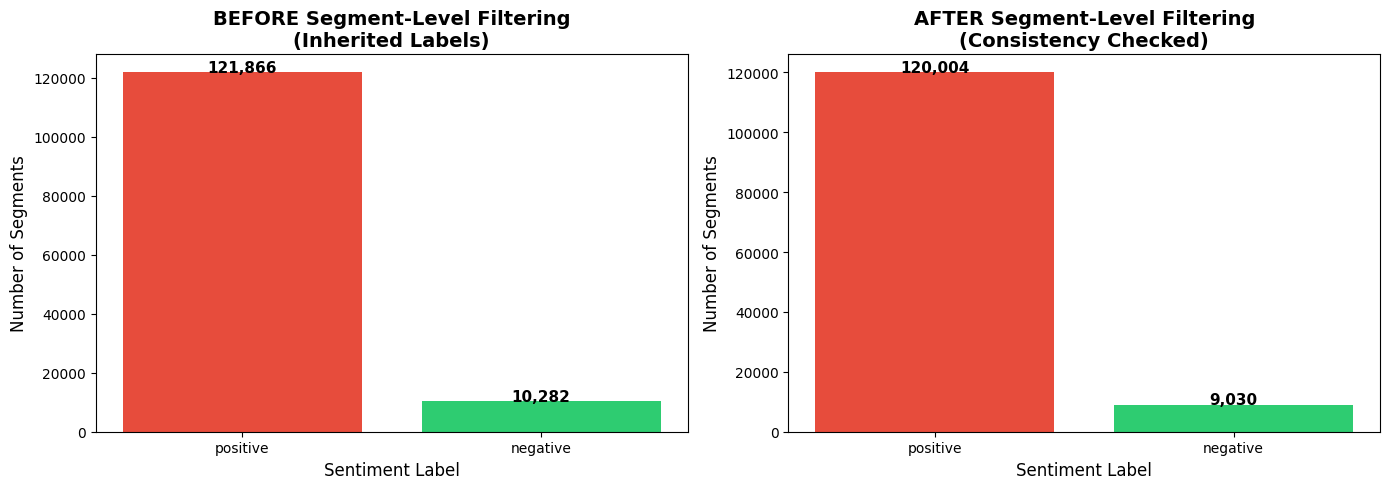


NOISE REDUCTION SUMMARY
Segments removed:         3,114
Noise reduction rate:     2.4%


In [ ]:
# ============================================================
# COMPARE BEFORE vs AFTER FILTERING
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BEFORE filtering
before_counts = df_aspects_final_before_filter['Sentiment_Label'].value_counts()
axes[0].bar(before_counts.index, before_counts.values, color=['#e74c3c', '#2ecc71'])
axes[0].set_title('BEFORE Segment-Level Filtering\n(Inherited Labels)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Segments', fontsize=12)
axes[0].set_xlabel('Sentiment Label', fontsize=12)
for i, v in enumerate(before_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

# AFTER filtering
after_counts = df_aspects_final_after_filtering['Sentiment_Label'].value_counts()
axes[1].bar(after_counts.index, after_counts.values, color=['#e74c3c', '#2ecc71'])
axes[1].set_title('AFTER Segment-Level Filtering\n(Consistency Checked)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Segments', fontsize=12)
axes[1].set_xlabel('Sentiment Label', fontsize=12)
for i, v in enumerate(after_counts.values):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate improvement metrics
print(f"\n{'='*70}")
print("NOISE REDUCTION SUMMARY")
print(f"{'='*70}")
print(f"Segments removed:         {len(df_aspects_final_before_filter) - len(df_aspects_final_after_filtering):,}")
print(f"Noise reduction rate:     {inconsistency_rate:.1f}%")